## Importing/Downloading

In [1]:
!wget "https://www.dropbox.com/sh/a0xuhqtlgbez07q/AABllt0-FAVI8lUr9SpJOq4Ga?dl=0"

--2021-05-19 10:21:17--  https://www.dropbox.com/sh/a0xuhqtlgbez07q/AABllt0-FAVI8lUr9SpJOq4Ga?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/raw/a0xuhqtlgbez07q/AABllt0-FAVI8lUr9SpJOq4Ga [following]
--2021-05-19 10:21:17--  https://www.dropbox.com/sh/raw/a0xuhqtlgbez07q/AABllt0-FAVI8lUr9SpJOq4Ga
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3a422a0c0faac5b29f160d4b02.dl.dropboxusercontent.com/zip_download_get/AyKjsQwov_sZY70XBxPI85SubPJEwEZ-znkuIGKJYbdLJcCM8CzetFKS-QcCGUu-dsZclt9MdyWbTsUYNLUzagVG8uajHlphehBGtbk3AGSaUQ# [following]
--2021-05-19 10:21:18--  https://uc3a422a0c0faac5b29f160d4b02.dl.dropboxusercontent.com/zip_download_get/AyKjsQwov_sZY70XBxPI85SubPJEwEZ-znkuIGKJYbdLJcCM8CzetFKS-QcCGUu-dsZclt9MdyWbTsUY

In [2]:
!unzip "AABllt0-FAVI8lUr9SpJOq4Ga?dl=0"

Archive:  AABllt0-FAVI8lUr9SpJOq4Ga?dl=0
mapname:  conversion of  failed
 extracting: GK2_page-0358_edited.jpg  
 extracting: GK2_page-0358_cropped.jpg  
 extracting: GK2_page-0419_cropped.jpg  
 extracting: GK2_page-0379_cropped.jpg  
 extracting: GK2_page-0345_cropped.jpg  
 extracting: GK2_page-0344_cropped.jpg  
 extracting: GK2_page-0403_cropped.jpg  
 extracting: GK2_page-0418_cropped.jpg  
 extracting: GK2_page-0358_cropped(a).jpg  
 extracting: GK2_page-0360_cropped(a).jpg  
 extracting: GK2_page-0366_cropped(b).jpg  
 extracting: GK2_page-0358_cropped(b).jpg  
 extracting: GK2_page-0366_cropped(a).jpg  
 extracting: GK2_page-0360_cropped(b).jpg  

1 archive had fatal errors.


In [3]:
import cv2
import imutils
from imutils import contours as cont
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

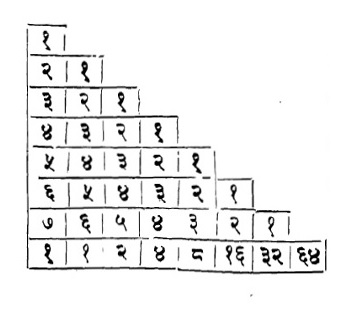

In [35]:
image = cv2.imread("GK2_page-0360_cropped(a).jpg") # This image is edited using paint
cv2_imshow(image)

## Gamma Adjustment

In [36]:
def adjust_gamma(image, gamma=1.0):
	# build a lookup table mapping the pixel values [0, 255] to
	# their adjusted gamma values
	invGamma = 1.0 / gamma
	table = np.array([((i / 255.0) ** invGamma) * 255
		for i in np.arange(0, 256)]).astype("uint8")
	# apply gamma correction using the lookup table
	return cv2.LUT(image, table)

In [37]:
original = image.copy()

In [38]:
for gamma in np.arange(0.0, 3.5, 0.5):
	# ignore when gamma is 1 (there will be no change to the image)
	if gamma == 1:
		continue
	# apply gamma correction and show the images
	gamma = gamma if gamma > 0 else 0.1
	adjusted = adjust_gamma(original, gamma=gamma)
	#cv2.putText(adjusted, "g={}".format(gamma), (10, 30),
	#	cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 3)
  
	cv2.imwrite("g={}".format(gamma)+'.jpg',adjusted)

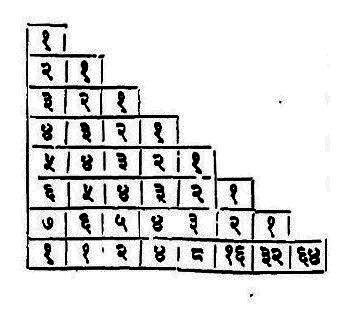

In [39]:
orig = cv2.imread("g=0.1.jpg")
cv2_imshow(orig)

## Image Processing - cell detection

In [40]:
def threshold(image, invert=False):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    #Thresholding the image
    thresh, img_bin = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    # Invert the image
    if invert: img_bin = 255-img_bin
    return img_bin

In [41]:
def morph(img_bin, kernel, iterations=2):
    img_temp = cv2.erode(img_bin, kernel, iterations=iterations)
    img_lines = cv2.dilate(img_temp, kernel, iterations=iterations)
    return img_lines

In [42]:
def image_process(image) : 
    #convert binary image
    img_bin = threshold(image, invert=True)

    # Defining a kernel length
    kernel_length = np.array(img_bin).shape[1]//40

    # A verticle kernel of (1 X kernel_length), to detect all the verticle lines.
    #verticle_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_length))
    # A horizontal kernel of (kernel_length X 1), to detect all the horizontal lines.
    #horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_length, 1))
    line_min_width = 15
    kernal_h = np.ones((1,line_min_width), np.uint8)
    kernal_v = np.ones((line_min_width,1), np.uint8)

    verticle_lines = morph(img_bin, kernal_v)
    horizontal_lines = morph(img_bin, kernal_h)

    img_bin_hori = horizontal(horizontal_lines)
    img_bin_ver = vertical(verticle_lines)

    img_bin_final=img_bin_hori|img_bin_ver
    img_bin_final_ori = 255-img_bin_final
    return img_bin_final_ori

In [43]:
def find_boxes(image):
    #convert binary image
    img_bin = threshold(image, invert=True)

    # Defining a kernel length
    kernel_length = np.array(img_bin).shape[1]//40

    # A verticle kernel of (1 X kernel_length), to detect all the verticle lines.
    verticle_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_length))
    # A horizontal kernel of (kernel_length X 1), to detect all the horizontal lines.
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_length, 1))
    
    verticle_lines = morph(img_bin, verticle_kernel)
    horizontal_lines = morph(img_bin, horizontal_kernel)
    #plot(verticle_lines,'gray')
    #print(type(verticle_lines))
    boxes = cv2.add(verticle_lines, horizontal_lines)

    return boxes

In [44]:
def horizontal(img_bin_hori):
  edges = cv2.Canny(img_bin_hori,50,150,apertureSize = 3)

  lines_horizontal = cv2.HoughLinesP(edges, 1, np.pi/180, 30)

  lines_horizontal_custom = []
  for line in lines_horizontal:
    lines_horizontal_custom.append(line[0])

  lines_horizontal_sorted = sorted(lines_horizontal_custom,key=lambda x: x[0]) # previously key was x[1] 

  print(lines_horizontal_sorted[0])
  print(lines_horizontal_sorted[-1])
  min_x = min(lines_horizontal_sorted[0][0],lines_horizontal_sorted[0][2])
  max_x = max(lines_horizontal_sorted[-1][2],lines_horizontal_sorted[-1][0])
  print(min_x,"::",max_x)
  custom_img_hori = img_bin_hori.copy()
  idx = 1
  for line in lines_horizontal_sorted:
    x1, y1 ,x2, y2 = line
    x1 = min_x -10 # 16
    x2 = max_x +10 # 542
    line_thickness = 2
    idx+=1
    cv2.line(custom_img_hori, (x1, y1), (x2, y2), (255, 255, 255), thickness=line_thickness)
  #cv2_imshow(custom_img_hori)
  thinned_hori = cv2.ximgproc.thinning(custom_img_hori)
  return thinned_hori
  print(idx)

In [45]:
def vertical(img_bin_vertical):
  edges = cv2.Canny(img_bin_vertical,50,150,apertureSize = 3)

  lines_vertical = cv2.HoughLinesP(edges, 1, np.pi/180, 30)

  lines_vertical_custom = []
  for line in lines_vertical:
    lines_vertical_custom.append(line[0])

  lines_vertical_sorted = sorted(lines_vertical_custom,key=lambda x: x[1]) # previously key was x[0]

  print(lines_vertical_sorted[0])
  print(lines_vertical_sorted[-1])
  min_y = min(lines_vertical_sorted[0][1],lines_vertical_sorted[0][3])
  max_y = max(lines_vertical_sorted[-1][1],lines_vertical_sorted[-1][3])

  custom_img = img_bin_vertical.copy()
  idx = 1
  for line in lines_vertical_sorted:
    x1, y1 ,x2, y2 = line
    y1 = min_y -10 # 17
    y2=max_y +10 # 500
    line_thickness = 2
    idx+=1
    cv2.line(custom_img, (x1, y1), (x2, y2), (255, 255, 255), thickness=line_thickness)
  #cv2_imshow(custom_img)
  thinned_ver = cv2.ximgproc.thinning(custom_img)
  return thinned_ver
  print(idx)

In [46]:
def over_draw_boxes(img_bin):
    minLineLength=100
    lines = cv2.HoughLinesP(image=img_bin,rho=1,theta=np.pi/180, threshold=100,lines=np.array([]), minLineLength=minLineLength,maxLineGap=80)
    for i in range(lines.shape[0]):
        cv2.line(img_bin, (lines[i][0][0], lines[i][0][1]), (lines[i][0][2], lines[i][0][3]), (255, 255, 255), 2, cv2.LINE_AA)

    #cv2_imshow(img_bin)
    return img_bin

In [47]:
def plot(image,cmap=None):
    plt.figure(figsize=(15,15))
    plt.imshow(image,cmap=cmap)

In [48]:
orig.shape

(314, 343, 3)

In [49]:
#resizing image
img = orig.copy()
img_original = img.copy()

In [50]:
processed_image = image_process(img)

[ 26 266 174 266]
[304 273 323 273]
26 :: 323
[25 57 25 29]
[324 271 324 240]


In [51]:
processed_image.shape

(314, 343)

In [52]:
enlarged_processed_image = imutils.resize(processed_image,width=2964) 

In [53]:
boxes = find_boxes(enlarged_processed_image)
boxes = over_draw_boxes(boxes)

In [54]:
len(boxes)

2713

In [55]:
contours, _ = cv2.findContours(boxes, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [56]:
len(contours)

57

In [57]:
(contours, boundingBoxes) = cont.sort_contours(contours, method="left-to-right")
(contours, boundingBoxes) = cont.sort_contours(contours, method="top-to-bottom")

In [58]:
img_original = imutils.resize(img_original,width=2964)

In [59]:

idx = 0
box_dict = {} # This dict contains bounding box for every cell having key as a number assigned to the cell
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)

    if (w > 20 and h > 10) and w > 1*h:
        #rectangular contours
        rect = cv2.minAreaRect(cnt)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        img = cv2.drawContours(img_original, [box], 0, (0,0,255), 3)


        #cell mappings
        M = cv2.moments(cnt)
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
        center = (cx, cy+20)
        if idx!=0:
            cv2.putText(img, str(idx), center, cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,255), 3)
            cv2.imwrite("cropped/0.jpg", img)

        box_dict[idx] = [x,y,h,w]
        #imshow("image", img)
        idx+=1

In [60]:
img =imutils.resize(img,width = 800)

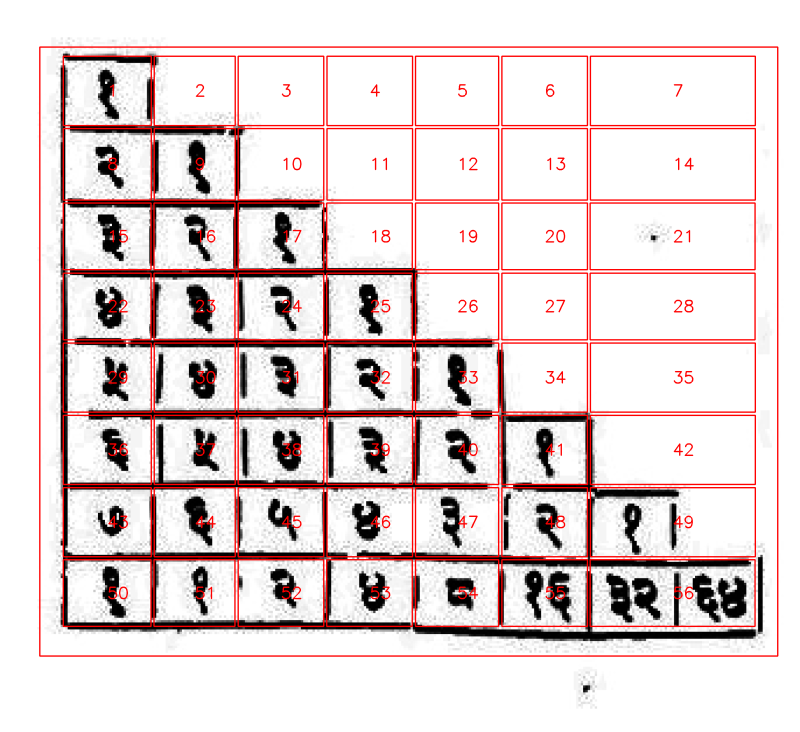

In [61]:
cv2_imshow(img)

In [62]:
box_dict

{0: [147, 174, 2258, 2735],
 1: [234, 208, 258, 327],
 2: [571, 208, 258, 301],
 3: [882, 208, 258, 318],
 4: [1211, 208, 258, 318],
 5: [1539, 208, 258, 309],
 6: [1859, 208, 258, 318],
 7: [2187, 208, 258, 612],
 8: [234, 476, 266, 327],
 9: [571, 476, 266, 301],
 10: [882, 476, 266, 318],
 11: [1211, 476, 266, 318],
 12: [1539, 476, 266, 309],
 13: [1859, 476, 266, 318],
 14: [2187, 476, 266, 612],
 15: [234, 753, 248, 327],
 16: [571, 753, 248, 301],
 17: [882, 753, 248, 318],
 18: [1211, 753, 248, 318],
 19: [1539, 753, 248, 309],
 20: [1859, 753, 248, 318],
 21: [2187, 753, 248, 612],
 22: [234, 1012, 248, 327],
 23: [571, 1012, 248, 301],
 24: [882, 1012, 248, 318],
 25: [1211, 1012, 248, 318],
 26: [1539, 1012, 248, 309],
 27: [1859, 1012, 248, 318],
 28: [2187, 1012, 248, 612],
 29: [234, 1271, 257, 327],
 30: [571, 1271, 257, 301],
 31: [882, 1271, 257, 318],
 32: [1211, 1271, 257, 318],
 33: [1539, 1271, 257, 309],
 34: [1859, 1271, 257, 318],
 35: [2187, 1271, 257, 612],
 3

## Cropping the table

In [63]:
def extract_table(num1,num2,table_image):

  start_cell = box_dict[num1]
  end_cell = box_dict[num2]

  start_x = start_cell[0]
  start_y = start_cell[1]
  end_x = end_cell[0]+end_cell[3]
  end_y = end_cell[1]+end_cell[2]

  table_image = imutils.resize(table_image,width = 2964) #previously it was 2564

  ROI = table_image[start_y:end_y, start_x:end_x]    
  # draw the bounding box on the image
  cv2.rectangle(table_image, (start_x, start_y), (end_x, end_y), (0,0,255), 2)
  cv2.imwrite('Extracted_table_'+str(num1)+'_to_'+str(num2)+'.png', ROI)


In [64]:
im_01 = orig.copy()
im_02 = orig.copy()

In [65]:
extract_table(23,48,im_01) # here num1 is the top_left cell number of the desired table
                          # and num2 is the bottom_right cell number of the desired table

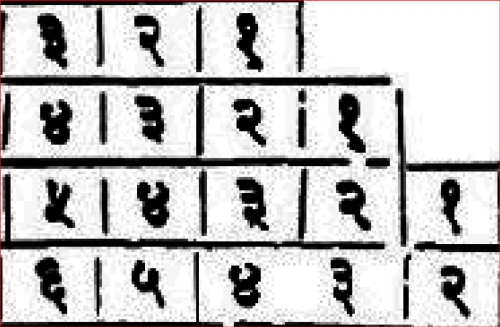

In [66]:
sample=cv2.imread('Extracted_table_23_to_48.png')
sample = imutils.resize(sample,width=500)
cv2_imshow(sample)

In [67]:
extract_table(1,33,im_02)

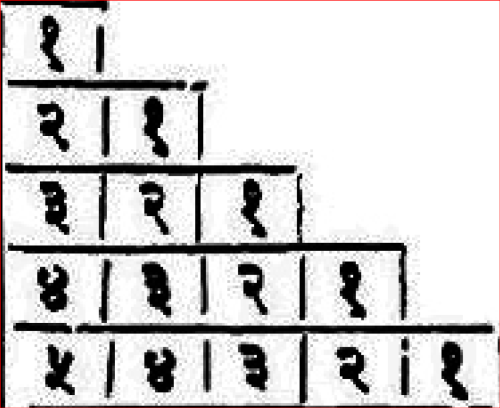

In [68]:
sample_2=cv2.imread('Extracted_table_1_to_33.png')
sample_2 = imutils.resize(sample_2,width=500)
cv2_imshow(sample_2)